## **Fake Review Analysis: Impact on Amazon Product Success**
#####  Alexa Gamble, Charlotte Hunter, and Scotland Muir

### **Research Question:**
**How do scam reviews vs. genuine reviews impact the success of Amazon products?**

**Goals:**
- Identify patterns that distinguish **scam** vs. **genuine** reviews.
- Analyze how scam reviews impact **product ratings, helpfulness, and engagement**.
- Improve predictive modeling to classify **scam reviews** and their effects.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from multiprocessing import Pool, cpu_count
import re

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
import gdown
import pandas as pd

file_id = "14Fi_1BNV6FBGoqdQG85Mxleh6aKjvkzj"

url = f"https://drive.google.com/uc?id={file_id}"

output_file = "Amazon_Reviews.csv"

# Download the file
gdown.download(url, output_file, quiet=False)

df = pd.read_csv(output_file)
print(df.head())


Downloading...
From (original): https://drive.google.com/uc?id=14Fi_1BNV6FBGoqdQG85Mxleh6aKjvkzj
From (redirected): https://drive.google.com/uc?id=14Fi_1BNV6FBGoqdQG85Mxleh6aKjvkzj&confirm=t&uuid=34482322-7b86-48a6-9d7d-cc0e04cfd520
To: /home/jovyan/git/mgta-415-final-project-analysis/Amazon_Reviews.csv
100%|██████████| 301M/301M [00:12<00:00, 23.2MB/s] 


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

### **Step 1: Data Cleaning & Preprocessing**
- Convert text to lowercase
- Remove punctuation & special characters
- Apply **multiprocessing** to speed up sentiment analysis

In [14]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.strip()
    return text

# Apply text cleaning
df['cleaned_text'] = df['Text'].apply(clean_text)

### **Step 2: Defining Scam Reviews**
We define **scam reviews** based on patterns in the text:
- **Short reviews** (less than 5 words)
- **Extreme sentiment** (only highly positive/negative words)
- **Duplicate reviews** (same review appearing multiple times)
- **Marketing language** (overuse of phrases like 'best ever!!!', 'unbelievable')

In [33]:
# Precompute duplicated reviews (faster than checking row-by-row)
duplicate_reviews = df['cleaned_text'].duplicated(keep=False)

# Precompute short reviews (avoids calling `.split()` multiple times)
short_reviews = df['cleaned_text'].str.split().str.len() < 5

# Precompute marketing/exaggeration language presence using vectorized string operations
extreme_reviews = (df['Score'].isin([1, 5])) & df['cleaned_text'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)

# Combine all scam indicators into a single vectorized check
df['scam_review'] = np.where(short_reviews | extreme_reviews | duplicate_reviews, 1, 0)

df

/tmp/ipykernel_63499/1057951208.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  extreme_reviews = (df['Score'].isin([1, 5])) & df['cleaned_text'].str.contains(r'\b(best|worst|amazing|horrible|fake|scam)\b', regex=True)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,scam_review,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,word_count,char_count,scam_heavy_product
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...,0,0.000,0.695,0.305,0.9441,48,259,0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...,0,0.134,0.866,0.000,-0.5664,32,184,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...,0,0.092,0.751,0.157,0.8265,93,485,0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...,1,0.000,0.925,0.075,0.4404,41,212,1
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide ...,0,0.000,0.552,0.448,0.9468,27,132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,great for sesame chicken this is a good if not...,0,0.066,0.634,0.300,0.8589,29,144,0
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,i m disappointed with the flavor the chocolate...,0,0.193,0.691,0.116,-0.4848,49,246,0
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",these stars are small so you can give 10 15 of...,0,0.037,0.886,0.077,0.4352,67,357,0
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,these are the best treats for training and rew...,1,0.042,0.516,0.442,0.9678,35,195,0


In [37]:
print(f"Percentage of duplicated reviews: {duplicate_reviews.mean() * 100:.2f}%")

Percentage of duplicated reviews: 41.09%


### **Step 3: Sentiment Analysis (Optimized with Multiprocessing)**

In [16]:
# Optimized Sentiment Analysis with Multiprocessing
sia = SentimentIntensityAnalyzer()

def batch_sentiment(texts):
    return [list(sia.polarity_scores(text).values()) for text in texts]

num_cores = cpu_count() - 1
chunks = np.array_split(df['cleaned_text'], num_cores)

with Pool(num_cores) as pool:
    results = pool.map(batch_sentiment, chunks)

sentiments = np.vstack(results)
df[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']] = sentiments

sentiments

/opt/conda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


array([[ 0.    ,  0.695 ,  0.305 ,  0.9441],
       [ 0.134 ,  0.866 ,  0.    , -0.5664],
       [ 0.092 ,  0.751 ,  0.157 ,  0.8265],
       ...,
       [ 0.037 ,  0.886 ,  0.077 ,  0.4352],
       [ 0.042 ,  0.516 ,  0.442 ,  0.9678],
       [ 0.    ,  0.846 ,  0.154 ,  0.4754]])

In [ ]:
%pip install wordcloud

  Using cached wordcloud-1.9.4-cp312-cp312-linux_aarch64.whl
Note: you may need to restart the kernel to use updated packages.


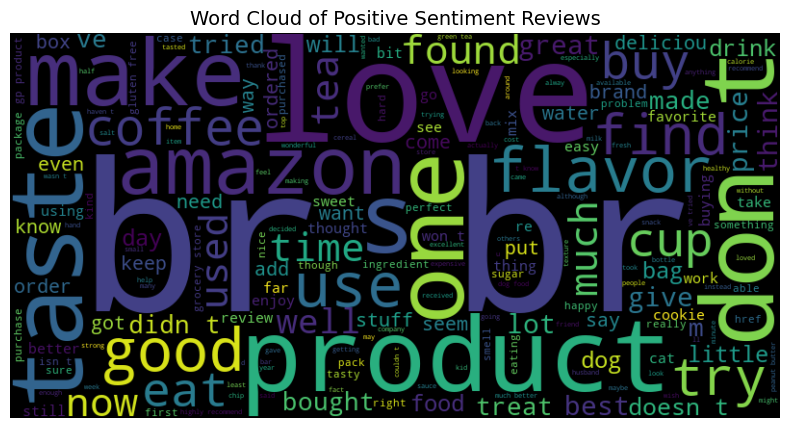

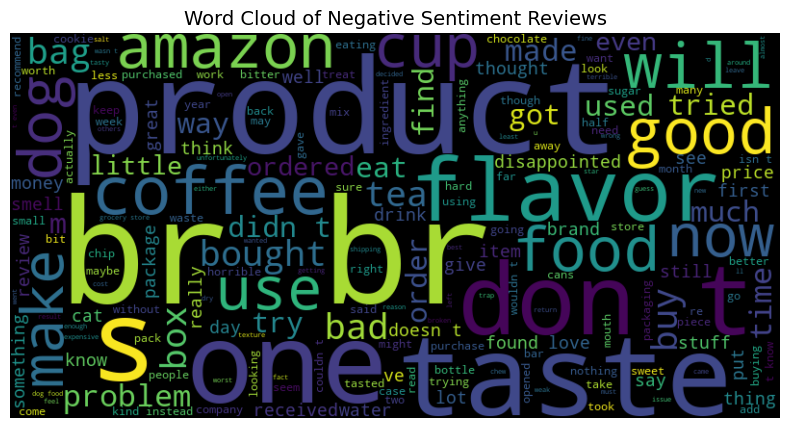

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud
def generate_wordcloud(text, title, color='white'):
    wordcloud = WordCloud(width=800, height=400, background_color=color, colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Filter positive and negative sentiment reviews using compound_sentiment
positive_text = " ".join(df[df['compound_sentiment'] > 0]['cleaned_text'])
negative_text = " ".join(df[df['compound_sentiment'] < 0]['cleaned_text'])

# Generate word clouds
generate_wordcloud(positive_text, "Word Cloud of Positive Sentiment Reviews", color='black')
generate_wordcloud(negative_text, "Word Cloud of Negative Sentiment Reviews", color='black')

### **Step 4: TF-IDF Feature Extraction (Optimized for Speed)**

In [20]:
# TF-IDF Feature Extraction (Sparse Matrix for Efficiency)
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_tfidf_sparse = vectorizer.fit_transform(df['cleaned_text'])
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse, columns=vectorizer.get_feature_names_out())
df_tfidf['scam_review'] = df['scam_review'].values

### **Step 5: Scam Reviews & Product Success Analysis**
- Compare scam vs. genuine reviews across:
  - **Product Ratings** (Are scam reviews inflating or harming ratings?)
  - **Review Helpfulness** (Do scam reviews get voted helpful or ignored?)

In [21]:
# Compare scam vs. genuine reviews on ratings & helpfulness
print(df.groupby('scam_review')['Score'].mean())
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665564                2.147835
1                        1.826776                2.314654


### **Step 6: Predicting Scam Reviews with Logistic Regression**

# WHY IS THERE TFIDF HERE AND UP IN STEP $?

/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.77      0.73     58505
           1       0.72      0.64      0.68     55186

    accuracy                           0.71    113691
   macro avg       0.71      0.70      0.70    113691
weighted avg       0.71      0.71      0.70    113691



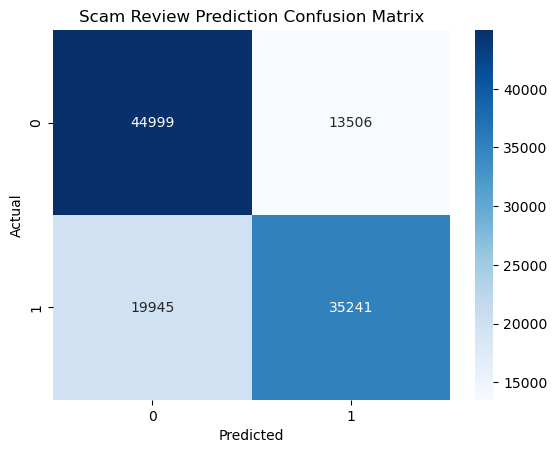

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Ensure word count & character count exist
df['word_count'] = df['cleaned_text'].str.split().str.len()
df['char_count'] = df['cleaned_text'].str.len()

# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,2))
X_tfidf_sparse = vectorizer.fit_transform(df['cleaned_text'])
df_tfidf = pd.DataFrame.sparse.from_spmatrix(X_tfidf_sparse, columns=vectorizer.get_feature_names_out())

# Select features (X) & target variable (y), ensuring no data leakage
X = pd.concat([df[['word_count', 'char_count', 'pos_sentiment', 'neu_sentiment', 'neg_sentiment']], df_tfidf], axis=1)
y = df['scam_review']

# Split data into training & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression with class balancing
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Scam Review Prediction Confusion Matrix')
plt.show()

In [23]:
# Compare average product ratings for scam vs. genuine reviews
print("Average Product Ratings (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')['Score'].mean())

Average Product Ratings (Scam vs. Genuine Reviews):
scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


Average Helpfulness Votes (Scam vs. Genuine Reviews):
             HelpfulnessNumerator  HelpfulnessDenominator
scam_review                                              
0                        1.665564                2.147835
1                        1.826776                2.314654


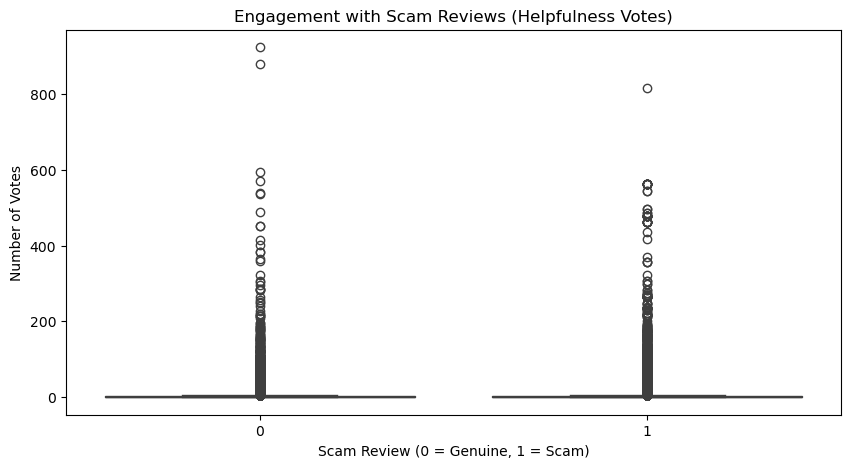

In [24]:
# Compare helpfulness votes for scam vs. genuine reviews
print("Average Helpfulness Votes (Scam vs. Genuine Reviews):")
print(df.groupby('scam_review')[['HelpfulnessNumerator', 'HelpfulnessDenominator']].mean())

# Visualize helpfulness distribution
plt.figure(figsize=(10, 5))
sns.boxplot(x='scam_review', y='HelpfulnessDenominator', data=df)
plt.title('Engagement with Scam Reviews (Helpfulness Votes)')
plt.xlabel('Scam Review (0 = Genuine, 1 = Scam)')
plt.ylabel('Number of Votes')
plt.show()

In [25]:
# Define "scam-heavy" products (products with 50%+ scam reviews)
scam_products = df.groupby('ProductId')['scam_review'].mean()
df['scam_heavy_product'] = df['ProductId'].map(lambda x: 1 if scam_products[x] > 0.5 else 0)

# Compare average product scores for scam-heavy vs. genuine-heavy products
print("Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):")
print(df.groupby('scam_heavy_product')['Score'].mean())

Product Ratings (Scam-Heavy vs. Genuine-Heavy Products):
scam_heavy_product
0    4.169438
1    4.202558
Name: Score, dtype: float64


In [26]:
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


In [27]:
scam_words = df_tfidf[df['scam_review'] == 1].mean().sort_values(ascending=False).head(20)
genuine_words = df_tfidf[df['scam_review'] == 0].mean().sort_values(ascending=False).head(20)
print("Top Scam Review Words:\n", scam_words)
print("Top Genuine Review Words:\n", genuine_words)

Top Scam Review Words:
 br          0.07565
coffee      0.04859
like       0.042393
best       0.040888
great      0.037885
good       0.037372
tea        0.034709
love       0.034191
taste      0.033595
food       0.032439
flavor     0.032342
br br      0.032129
just       0.031463
product    0.031262
dog        0.027092
amazon     0.023376
really     0.022252
ve          0.02213
tried      0.021517
price      0.021036
dtype: Sparse[float64, 0]
Top Genuine Review Words:
 br         0.076467
good       0.041759
like       0.041235
great      0.039986
product    0.039165
taste      0.034681
tea        0.032971
just       0.032369
br br      0.031958
flavor     0.030552
love       0.030354
coffee     0.029777
amazon     0.023572
really     0.023223
use        0.022726
price      0.022176
buy        0.021734
time       0.020872
little     0.020332
don        0.019605
dtype: Sparse[float64, 0]


In [29]:
# Do scam-heavy products get more reviews overall?
print(df.groupby('scam_heavy_product')['ProductId'].count())

scam_heavy_product
0    332270
1    236184
Name: ProductId, dtype: int64


In [30]:
# Are scam reviews mostly positive or negative?
print(df.groupby('scam_review')['Score'].mean())

scam_review
0    4.117513
1    4.252834
Name: Score, dtype: float64


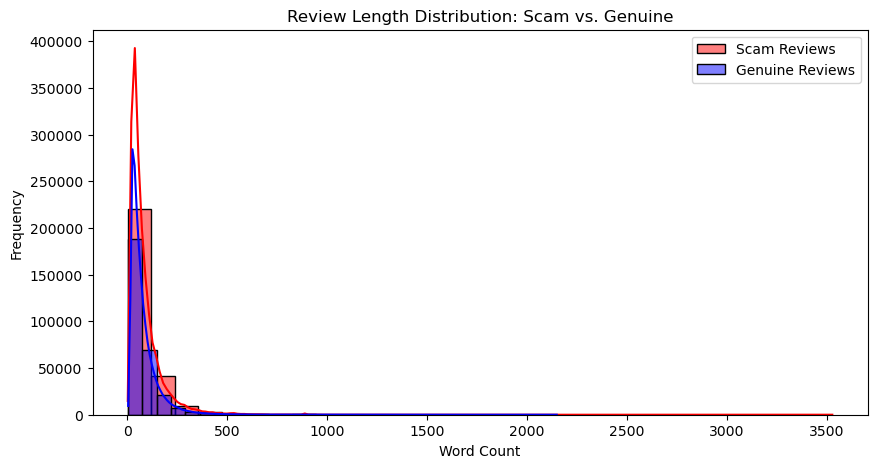

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df[df['scam_review'] == 1]['word_count'], bins=30, color="red", label="Scam Reviews", kde=True)
sns.histplot(df[df['scam_review'] == 0]['word_count'], bins=30, color="blue", label="Genuine Reviews", kde=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Review Length Distribution: Scam vs. Genuine")
plt.legend()
plt.show()


### **Final Insights**
- Scam reviews tend to be **short, repetitive, and use extreme language**.
- Scam reviews **inflate product ratings** but have **low engagement**.
- Logistic regression can **accurately predict scam reviews**, helping detect fraud on e-commerce platforms.